## QBUS3850 Lab 5 (SARIMA) Task


In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels as sm 
import statsmodels.api as smt
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Make larger plots
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#### 1. Use a SARIMA model on the forecast competition (NEM) data.
 - Identify the season $m$ and the orders of differencing $(d,D)$.
 - Plot the ACF and PACF.
 - Identify the non-seasonal part of the model $(p,q)$.
 - Identify the seasonal part of the model $(P,Q)$.
 - Generate forecasts from the training set and compare to the test set.

SETTLEMENTDATE
2020-03-18    7290.938542
2020-03-19    7696.435000
2020-03-20    7990.082500
2020-03-21    7006.861250
2020-03-22    6786.752500
Name: TOTALDEMAND, dtype: float64


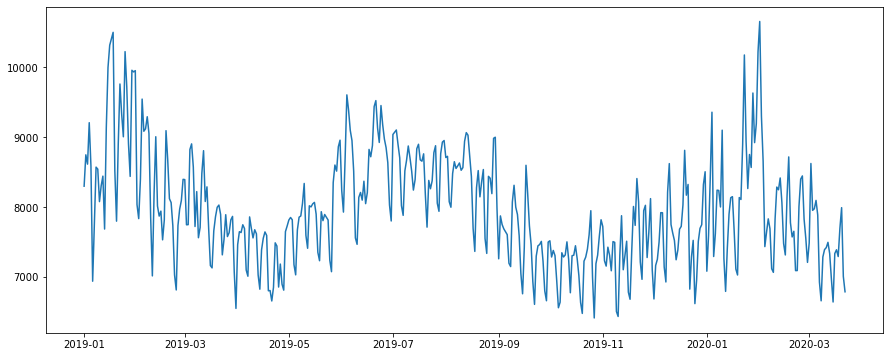

In [2]:
## Feel free to use your own NEM data, if you prefer.
filename = "nem-resample.csv"
ts = pd.read_csv( filename, index_col='SETTLEMENTDATE', parse_dates=True )

y = ts['TOTALDEMAND'][:-1]
print( y.tail() )

plt.plot( y )

## Split into training set and test set.
today = pd.to_datetime( dt.date( 2020, 3, 13 ) )
assert( today.dayofweek == 4 ) ## 4 is Friday

split = y.index.get_loc( today )
assert( y[ split ] == y[ today ] )

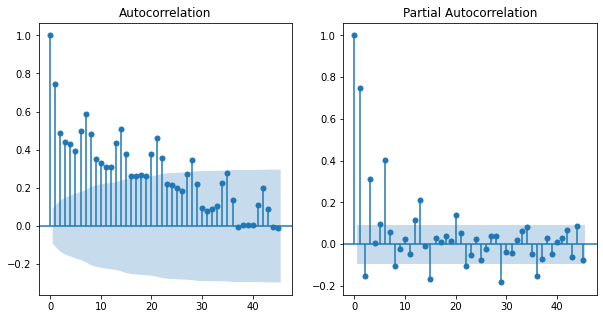

In [3]:
fig, ax = plt.subplots( 1, 2, figsize=(10,5) )
smt.graphics.tsa.plot_acf( y, lags=45, alpha = 0.05, ax=ax[0] )
smt.graphics.tsa.plot_pacf( y, lags=45, alpha = 0.05, ax=ax[1] )
print()

## Data apears not to be clearly trending
## Seasonal autocorrelations are not dying off quickly, suggesting 
## a difference (d=1; not strongly supported by data plot) and/or (more likely) a seasonal difference (D=1) is required.

## Autocorrelation peaks at 7,14,... suggest season m=7; as is common for daily data.


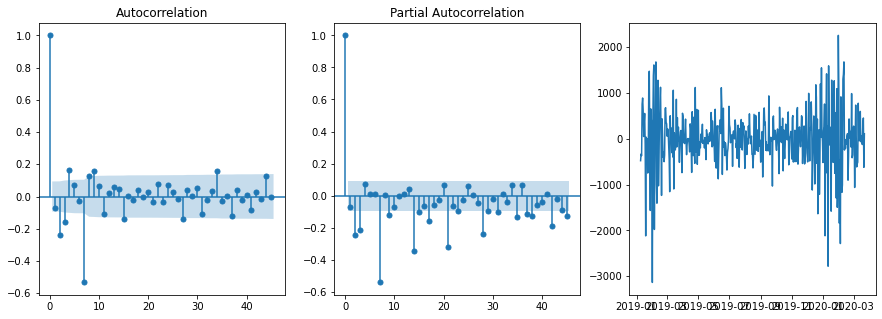

In [8]:
## I try d=1, D=1  (other choices, e.g. d=0, D=1, should also be tried and assessed)
## Differencing (d=1).
y_diff = y - y.shift()
y_diff.dropna( inplace=True )

## Seasonal differencing (D=1).
y_sdiff = y_diff - y_diff.shift(7)
y_sdiff.dropna( inplace=True )

## ACF/PACF.
fig, ax = plt.subplots( 1, 3, figsize=(15,5) )
plt.plot( y_sdiff )
smt.graphics.tsa.plot_acf( y_sdiff, lags=45, alpha = 0.05, ax=ax[0] )
smt.graphics.tsa.plot_pacf( y_sdiff, lags=45, alpha = 0.05, ax=ax[1] )
print()

Seasonally and 1st differenced data appear mean stationary; ACF, PACF on seasonally and 1st differenced data die down or cut off reasonably quickly:

__Non-seasonal part:__
 - ACF cuts off at $q=4$ or (more likely) dies down; PACF cuts off at $p=3$.
 - Suggests $p=3, q=0$.

__Seasonal part:__
 - ACF seasonal lags show single (negative) spike at 7, PACF seasonal lags show exponential decay.
 - Suggests $P=0, Q=1$.

In [9]:
p,d,q = 3,1,0
P,D,Q = 0,1,1
m = 7

fit2 = SARIMAX( y[:split], order=( p, d, q ), seasonal_order=( P, D, Q, m ) ).fit()
print( fit2.summary() )

C:\Users\rgerlach\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\rgerlach\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                         TOTALDEMAND   No. Observations:                  437
Model:             SARIMAX(3, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -3202.473
Date:                             Wed, 24 Mar 2021   AIC                           6414.946
Time:                                     11:03:28   BIC                           6435.253
Sample:                                 01-01-2019   HQIC                          6422.966
                                      - 03-12-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1095      0.036     -3.038      0.002      -0.180      -0.039
ar.L2         -0.2888      

205,6869,6592,7282,7522,7386,7452,7432


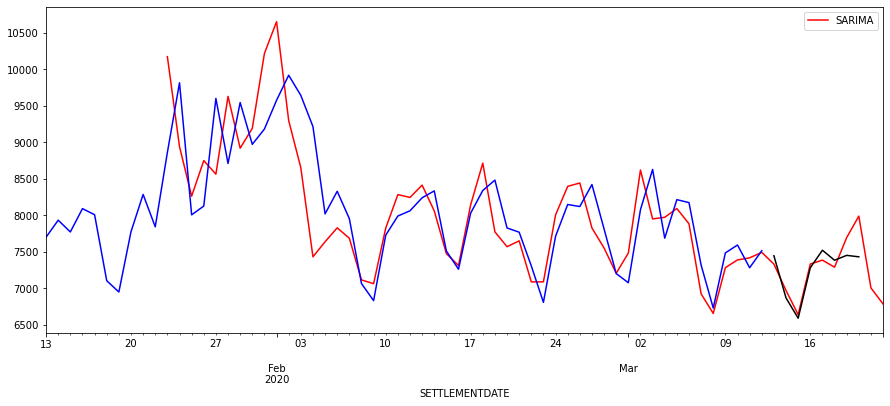

In [10]:
y2 = fit2.fittedvalues.rename( 'SARIMA' )
f2 = fit2.forecast(8)

y[-60:].plot( color='red')
y2[-60:].plot( color='blue', legend=True )
f2.plot( color='black' )

fc_sarima = f2[1:8]
id_sarima = 205
print( id_sarima, end=',')
print( ",".join( [ str( int(yy) ) for yy in fc_sarima ] ) )